In [1]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session as k

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

k(sess)

In [2]:
from keras import backend as K
import keras
import cv2
from Utils import *
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
from keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [3]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [4]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('Data1/X.npy')
Y = np.load('Data1/Y.npy')

In [5]:
print(X.shape , Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [6]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X = []
Y = []

In [7]:
#define model
# input : 512,512,3
# output : 16,16,1,5



def save_model(model):
    model_json = model.to_json()
    with open("model1/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

        
        
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    

    
    
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model



In [8]:
#define utils

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#checkpoint
checkpoint = ModelCheckpoint('model1/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [10]:
#load and save model
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

save_model(model)


/home/nitin/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [11]:
model.load_weights('model1/text_detect.h5')

In [12]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [13]:
hist = model.fit(X_train ,Y_train ,epochs= 3 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Train on 345 samples, validate on 116 samples
Epoch 1/3
345/345 [==============================] - 41s 119ms/step - loss: 2.3278 - accuracy: 0.0488 - val_loss: 3.2789 - val_accuracy: 0.0499

Epoch 00001: val_loss improved from inf to 3.27885, saving model to model1/text_detect.h5
Epoch 2/3
345/345 [==============================] - 33s 95ms/step - loss: 2.3548 - accuracy: 0.0477 - val_loss: 3.2596 - val_accuracy: 0.0472

Epoch 00002: val_loss improved from 3.27885 to 3.25963, saving model to model1/text_detect.h5
Epoch 3/3
345/345 [==============================] - 33s 96ms/step - loss: 2.3567 - accuracy: 0.0469 - val_loss: 3.5074 - val_accuracy: 0.0474

Epoch 00003: val_loss did not improve from 3.25963


In [14]:
#model.save_weights('model1/text_detect.h5')

In [15]:
model = load_model('model1/text_detect_model.json')
model.load_weights('model1/text_detect.h5')

In [16]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)
    
    

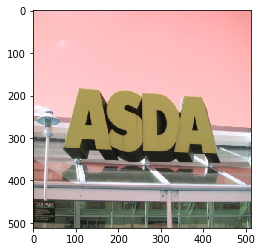

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


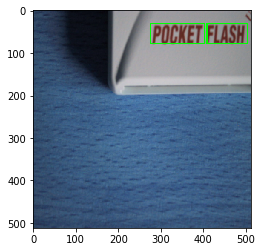

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


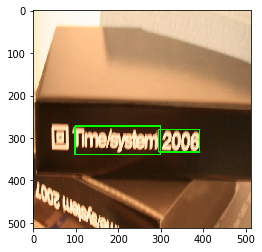

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


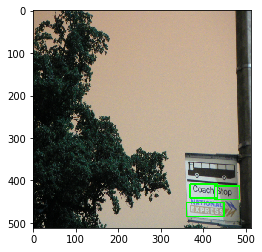

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


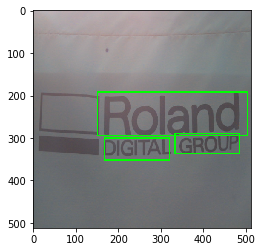

In [17]:
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    
    predict_func(model , X_val[i:i+1] , 0.5, i)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


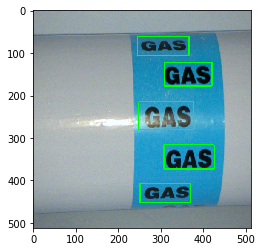

In [18]:
for i in os.listdir('Test'):
    img = cv2.imread(os.path.join('Test',i))
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model , np.expand_dims(img,axis= 0) , 0.5 , 'sample')

### THE END